In [1]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


2023-05-05 08:59:56.076972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os,random,math
TRAINING_DIR="propaganda_dataset_v2"

files=os.listdir(TRAINING_DIR)

trainingdf= pd.read_csv(os.path.join(TRAINING_DIR,files[1]),sep = '\t')
testingdf= pd.read_csv(os.path.join(TRAINING_DIR,files[2]),sep = '\t')

In [3]:
def convert_token(sentences):
    start_sent=sentences.split("<BOS>")
    end_sent=start_sent[1].split("<EOS>")
    return end_sent[0]

testingdf["tagged_in_context"]=testingdf["tagged_in_context"].map(convert_token)
trainingdf["tagged_in_context"]=trainingdf["tagged_in_context"].map(convert_token)

testingdf.head(10)

,label,tagged_in_context
0,not_propaganda,according to a UN estimate.
1,causal_oversimplification,the country would not last long without an ou...
2,appeal_to_fear_prejudice,gets Earl Warren and Sen. Richard Russel to j...
3,not_propaganda,You
4,repetition,infidels
5,"name_calling,labeling","the ""gay lifestyle"
6,loaded_language,devastating communities
7,not_propaganda,Jacob
8,flag_waving,Iran’s long rap sheet of aggression against A...
9,doubt,"Now, the pope’s reply to my testimony was: “I..."


In [4]:
trainingdf["label"].value_counts(dropna=False)

not_propaganda               1191
exaggeration,minimisation     164
causal_oversimplification     158
name_calling,labeling         157
loaded_language               154
appeal_to_fear_prejudice      151
flag_waving                   148
repetition                    147
doubt                         144
Name: label, dtype: int64

In [5]:
def convert_labels_multi(label):
    if label=="flag_waving":
        return 0
    elif label=="appeal_to_fear_prejudice":
        return 1
    elif label=="causal_oversimplification":
        return 2
    elif label =="doubt":
        return 3
    elif label == "exaggeration,minimisation":
        return 4
    elif label == "loaded_language":
        return 5
    elif label == "name_calling,labeling":
        return 6
    elif label == "repetition":
        return 7


testingdf=testingdf[testingdf.label != "not_propaganda"]
trainingdf = trainingdf[trainingdf.label != "not_propaganda"]

trainingdf["label"] = trainingdf["label"].map(convert_labels_multi)
testingdf["label"] = testingdf["label"].map(convert_labels_multi)

trainingdf.reset_index(inplace=True)
testingdf.reset_index(inplace = True)

In [6]:
trainingdf["label"].value_counts(dropna=False)

4    164
2    158
6    157
5    154
1    151
0    148
7    147
3    144
Name: label, dtype: int64

In [7]:
from keras.utils import to_categorical
y_train = to_categorical(trainingdf["label"])
y_test = to_categorical(testingdf["label"])


In [8]:
from keras.preprocessing.text import Tokenizer
no_words=10000
tokenizer=Tokenizer(num_words=no_words,lower=True)

In [9]:
mes = []
for i in trainingdf['tagged_in_context']:
    mes.append(i.split())
for i in testingdf['tagged_in_context']:
    mes.append(i.split())

In [10]:
tokenizer.fit_on_texts(mes)

In [11]:
X_train=tokenizer.texts_to_sequences(trainingdf["tagged_in_context"])
X_train_pad=pad_sequences(X_train,maxlen=140,padding='post') 
X_test = tokenizer.texts_to_sequences(testingdf["tagged_in_context"])
X_test_pad = pad_sequences(X_test, maxlen = 140, padding = 'post')


In [12]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

In [13]:
vector_size = 100
gensim_weight_matrix = np.zeros((no_words ,vector_size))
gensim_weight_matrix.shape
words = list(glove_gensim.key_to_index.keys())
for word, index in tokenizer.word_index.items():
    if index < no_words:  
        if word in  words:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [14]:
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.preprocessing import sequence

In [15]:
EMBEDDING_DIM = 100
class_num = 8
model = Sequential()
model.add(Embedding(input_dim = no_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))


model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dense(class_num, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam",metrics = "accuracy")






In [16]:
# EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [17]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_test_pad, y_test),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.9100 - accuracy: 0.2437
Epoch 1: val_accuracy improved from -inf to 0.26165, saving model to ./model.h5
11/11 [==============================] - 16s 1s/step - loss: 1.9100 - accuracy: 0.2437 - val_loss: 1.8068 - val_accuracy: 0.2616
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.6389 - accuracy: 0.3557
Epoch 2: val_accuracy improved from 0.26165 to 0.31900, saving model to ./model.h5
11/11 [==============================] - 11s 980ms/step - loss: 1.6389 - accuracy: 0.3557 - val_loss: 1.7480 - val_accuracy: 0.3190
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.4674 - accuracy: 0.4358
Epoch 3: val_accuracy improved from 0.31900 to 0.39785, saving model to ./model.h5
11/11 [==============================] - 11s 995ms/step - loss: 1.4674 - accuracy: 0.4358 - val_loss: 1.6853 - val_accuracy: 0.3978
Epoch 4/25
11/11 [==============================] - ETA: 0s - loss: 1.4180 - ac

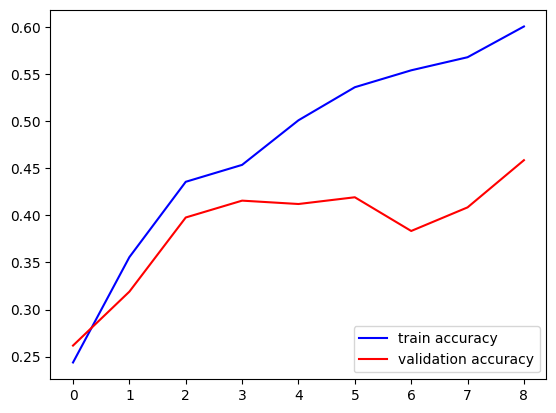

In [18]:
import matplotlib.pyplot as plt
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [19]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

9/9 [==============================] - 2s 124ms/step
              precision    recall  f1-score   support

           0       0.44      0.63      0.52        27
           1       0.60      0.49      0.54        53
           2       0.35      0.34      0.35        32
           3       0.45      0.50      0.47        34
           4       0.39      0.41      0.40        27
           5       0.43      0.59      0.50        27
           6       0.55      0.40      0.46        43
           7       0.41      0.36      0.38        36

    accuracy                           0.46       279
   macro avg       0.45      0.47      0.45       279
weighted avg       0.47      0.46      0.46       279



In [20]:
y_pred = model.predict(X_test_pad)
y_pred
threshold=0.5
convert_labels_multi = np.where(y_pred >= threshold, 1, 0)


y_pred = model.predict(X_test_pad)
y_pred = np.argmax (y_pred, axis = 1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_test, convert_labels_multi))
print("Precision: ", precision_score(y_test, convert_labels_multi, average='macro'))
print("Recall: ", recall_score(y_test, convert_labels_multi, average='macro'))
print("F1 Score: ", f1_score(y_test, convert_labels_multi, average='macro'))

9/9 [==============================] - 1s 125ms/step
Accuracy:  0.3118279569892473
Precision:  0.5230012871853547
Recall:  0.3084592069050355
F1 Score:  0.3628622995836655
